# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Nicholas Antonio Carroll, nicholas.carroll@studio.unibo.it - Laura Mazzuca, laura.mazzuca@studio.unibo.it

## Step B: Multiple Instance Detection


### Local Invariant Features with General Hough Transform Star Model

###### Offline phase
1. **Keypoint Detection**: Identify salient repeatable points (Keypoints) in model and scene images (with SIFT).
2. **Compute Descriptor**: 
    - compute barycentre **Pc** of all keypoints
    - compute voting parameter **Vi** for each keypoint **Ki** with position **Pi** as ***Vi = Pc -Pi***

###### Online phase
3. **Scene Keypoint Detection**: Match point from scene and model according to joining vectors detection.
4. **Match with Query Images**:
5. **GHT - vote for barycentre position**
4. **Position Estimation**: Estimate the position of the object in the scene image by using the votes for barycentre and then applying the transformation matrix resulting from the previous step to the angles of the bounding box

## Environment setup

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  #Connect to google drive folder, needed only if running notebook on colab
  from google.colab import drive
  drive.mount('/content/gdrive')

If working in colab install the correct version of opencv

In [2]:
if IN_COLAB:
  !pip install opencv-contrib-python==4.3.0.36

In [3]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

if IN_COLAB:
  scenes_location = 'gdrive/MyDrive/shelf-product-recognition/images/scenes/'
  models_location = 'gdrive/MyDrive/shelf-product-recognition/images/models/'
else:
  scenes_location = 'images/scenes/'
  models_location = 'images/models/'

scenes=['m1.png','m2.png','m3.png', 'm4.png','m5.png']
models=['0.jpg','1.jpg','11.jpg','19.jpg','24.jpg','25.jpg','26.jpg']

for i in range(len(scenes)):
  scenes[i] = scenes_location+scenes[i]

for i in range(len(models)):
  models[i] = models_location+models[i]

All the query images:

In [4]:
img_query = []
i=0
max_h = 0
resize = False
for p in models:
    img_query.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # queryImage
    if resize and max_h < img_query[i].shape[0]:
        max_h = img_query[i].shape[0]
    i=i+1

In [5]:
if resize:
    i=0
    for img in img_query:
        if img.shape[0] < max_h:
            height = int(max_h)
            width = int(img.shape[1]*max_h/img.shape[0])
            dim = (width, height)
            # resize image
            img_query[i] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        i=i+1

## Offline Phase

### 1. Keypoint Detection
Initialize the SIFT detector object in the following way:


In [194]:
# Initiate SIFT detector
if IN_COLAB:
    sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=5, contrastThreshold=0.11, sigma=1.4) #very good results with both resized and not resized images
else:
    sift = cv2.SIFT_create() #very good results with both resized and not resized images


Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of all the query images:

In [195]:
# find the keypoints and descriptors with SIFT
kp_query = []
for img in img_query:
    kp_query.append(sift.detect(img))

### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support). We will use the SIFT descriptor.

In [196]:
#Calculates the barycenter of the keypoints of an image
def calculateBarycenter(keyPoints):
    x=0
    y=0
    for kp in keyPoints:
        x += kp.pt[0]
        y += kp.pt[1]
    x = x/len(keyPoints)
    y = y/len(keyPoints)

    return (x,y)

In [197]:
#The extended keypoint class contains the coordinates of the point, angle, size, descriptor and the voting parameter
class ExtendedKeyPoint:
    def __init__(self, kp, pc, desc):
        self.kp = kp
        self.desc = desc
        #distance between barycenter and the point
        self.vi = np.sqrt(np.power(pc[0] - kp.pt[0], 2) + np.power(pc[1] - kp.pt[1], 2))


In [198]:
# Describing keypoints for query and train images
des_query = np.empty(len(img_query), dtype=object)

for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])

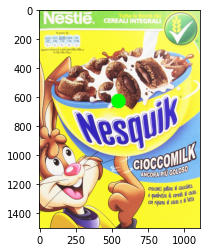

(545.4843704380356, 626.4694804722773)


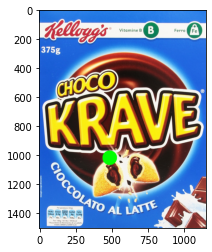

(485.4589665045117, 1016.0329053874004)


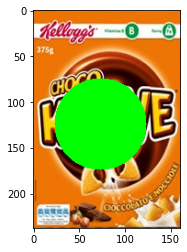

(73.38790736657702, 124.80229483110034)


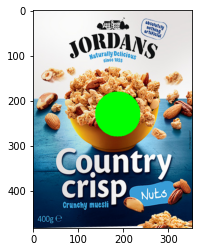

(187.1594385018782, 230.85300703430175)


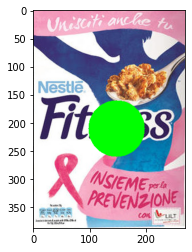

(148.8041879304698, 210.94999890663254)


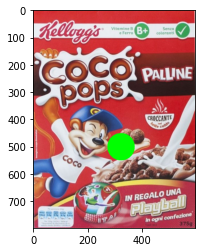

(321.54767662362934, 500.7611335818632)


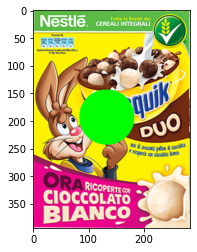

(133.74868482487963, 193.30016900917)


In [199]:
#Calculating extended Keypoints
img_query_rgb = []
for p in models:
    img_query_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage


kp_query_extended = []
for i in range(len(kp_query)):
    pc = calculateBarycenter(kp_query[i])
    kp_query_extended.append([])
    img_query_rgb[i] = cv2.circle(img_query_rgb[i], np.int32(pc), radius=50, color=(0,255,0), thickness=-1)
    plt.imshow(img_query_rgb[i])
    plt.show()
    print(pc)
    for k in range(len(kp_query[i])):
        kp_query_extended[i].append(ExtendedKeyPoint(kp_query[i][k], pc, des_query[i][k]))

## Online Phase

Load the train images:

In [200]:
img_train = []
for p in scenes:
    img_train.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # trainImage

### 3. Scene Keypoints Detection
Let us find the keypoints for the train images:

In [201]:
kp_train = []
for img in img_train:
    kp_train.append(sift.detect(img))

In [202]:
# Describing keypoints for query and train images
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])

### 4. Match with Query Images
We compute the matches with the usual KD Tree

In [203]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 500)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches_per_image = np.empty(len(img_train), dtype=object)
i = 0 #index for the train images

for des_t in des_train: #for each scene
    matches_per_image[i] = [] #create a list that will hold the matches wrt each model image
    for des_q in des_query: #for each query image
        matches_per_image[i].append(flann.knnMatch(des_q,des_t,k=2)) #compute at most 2 matches per keypoint matches
    i = i+1

In [232]:
good = np.empty(len(img_train), dtype=object)
i=0
j=0
for mat_img in matches_per_image:#for each list of matches related to an image wrt a train image
    good[i] = np.empty(len(img_query), dtype=object)
    j=0
    for matches in mat_img: # for each list of matches related to the train image j
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j=j+1
    i=i+1

In [233]:
# src_pts = []
# for m in good[0][4]:
#     src_pts.append(kp_train[0][m.trainIdx])
    
# img_visualization = cv2.drawKeypoints(img_train[0],src_pts,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.figure(figsize = (40,6))
# plt.imshow(img_visualization)
# plt.show()

### 5. GHT - cast votes for barycentre

In [234]:
def keypoint_barycentre_vote(query_ext_kp, matched_kp):
    s=query_ext_kp.kp.size/matched_kp.size
#    phi=query_ext_kp.kp.angle-matched_kp.angle
    return (int(matched_kp.pt[0]+s*query_ext_kp.vi), int(matched_kp.pt[1]+s*query_ext_kp.vi))

In [235]:
def most_voted_barycentres(bary_votes):
    max_bary = []
    max_votes = 0
    
    for barycentre in bary_votes:
        if bary_votes[barycentre] == max_votes:
            max_bary.append(barycentre)
        if bary_votes[barycentre] > max_votes:
            max_votes = bary_votes[barycentre]
            max_bary = []
            max_bary.append(barycentre)
            
    return [max_bary, max_votes]

In [236]:
barycenteres_votes = np.empty(len(img_train), dtype=object)
color = (0, 255, 0)
i=0
R=20
for mat_img in matches_per_image:#for each list of matches related to an image wrt a train image
    j = 0
    barycenteres_votes[i] = np.empty(len(img_query), dtype=dict)
    for matches in mat_img: # for each list of matches related to the query image j
        barycenteres_votes[i][j] = dict()
        for m in good[i][j]:
            bary_vote = keypoint_barycentre_vote(kp_query_extended[j][m.queryIdx],kp_train[i][m.trainIdx]) 
            
            if bary_vote in barycenteres_votes[i][j]:
                curr_votes = barycenteres_votes[i][j][bary_vote] + 1
            else:
                curr_votes = 1       
            barycenteres_votes[i][j][bary_vote] = curr_votes
        j+=1
    i+=1

[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (330, 660) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (334, 664) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (2294, 1529) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (2195, 1470) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (2868, 2246) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (1830, 1084) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (2963, 2033) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (1839, 1063) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (2586, 1810) added to image.
[scene images/scenes/m1.png - image images/models/0.jpg] barycentre (3174, 2245) added to image.
[scene images/scenes/m1.png - imag

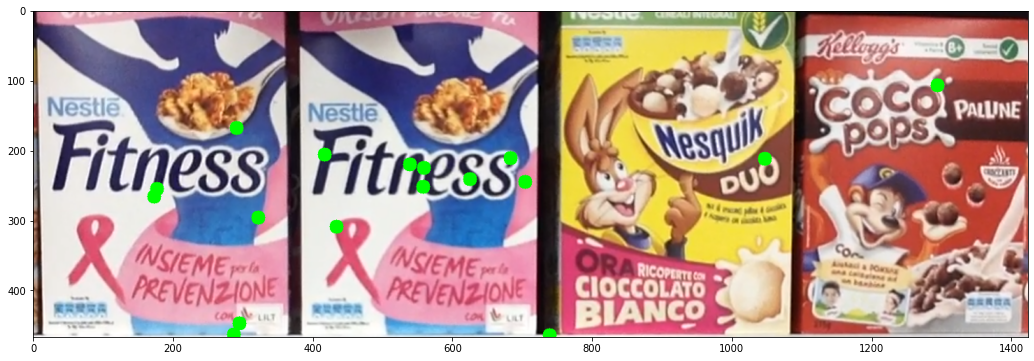

[scene images/scenes/m2.png - image images/models/0.jpg] barycentre (1494, 1750) added to image.
[scene images/scenes/m2.png - image images/models/0.jpg] barycentre (811, 984) added to image.
[scene images/scenes/m2.png - image images/models/0.jpg] barycentre (1111, 1107) added to image.
[scene images/scenes/m2.png - image images/models/0.jpg] found 3 barycentres with 3 votes.
[scene images/scenes/m2.png - image images/models/1.jpg] barycentre (2923, 2097) added to image.
[scene images/scenes/m2.png - image images/models/1.jpg] barycentre (4220, 3526) added to image.
[scene images/scenes/m2.png - image images/models/1.jpg] barycentre (766, 801) added to image.
[scene images/scenes/m2.png - image images/models/1.jpg] barycentre (5481, 4300) added to image.
[scene images/scenes/m2.png - image images/models/1.jpg] found 4 barycentres with 2 votes.
[scene images/scenes/m2.png - image images/models/11.jpg] barycentre (1192, 257) added to image.
[scene images/scenes/m2.png - image images/mod

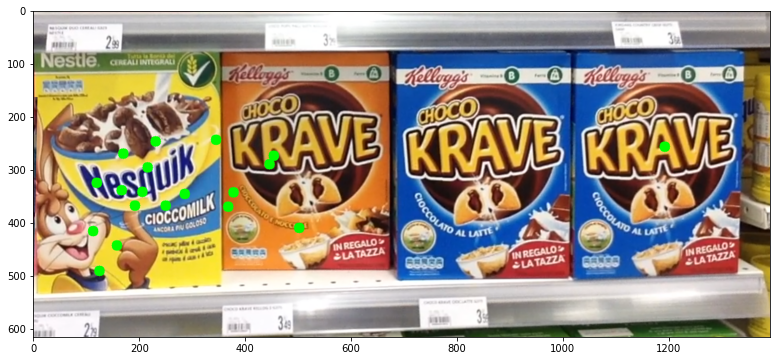

[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1448, 1388) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1368, 1359) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1051, 1018) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1313, 1269) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1078, 1014) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1255, 1203) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1569, 1509) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1870, 1805) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1202, 1086) added to image.
[scene images/scenes/m3.png - image images/models/0.jpg] barycentre (1513, 1411) added to image.
[scene images/scenes/m3.png - 

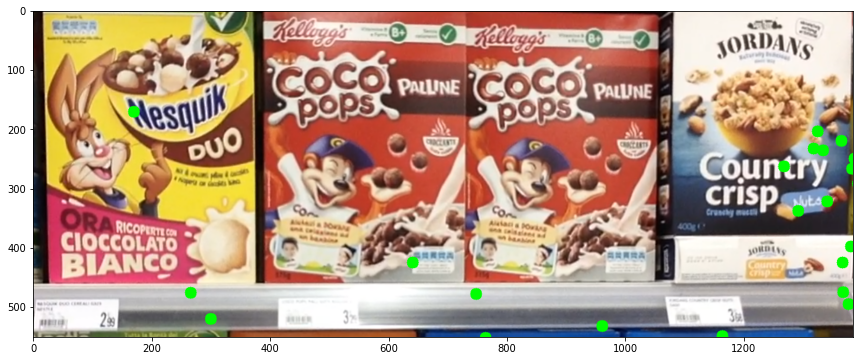

[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (4302, 3741) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (1152, 736) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (2108, 1362) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (2171, 1425) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (2433, 1707) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (1816, 1016) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (2588, 1787) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] barycentre (2257, 1420) added to image.
[scene images/scenes/m4.png - image images/models/0.jpg] found 8 barycentres with 2 votes.
[scene images/scenes/m4.png - image images/models/1.jpg] barycentre (5241, 3807) added to image.
[scene images/scenes/m4.png - image i

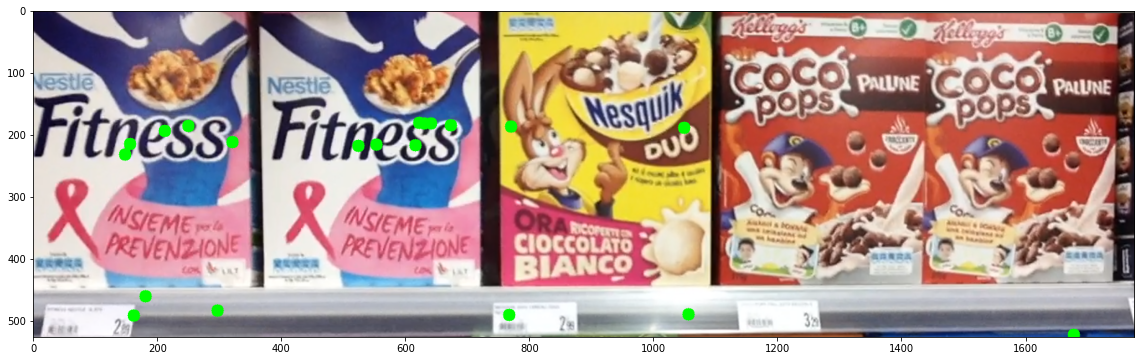

[scene images/scenes/m5.png - image images/models/0.jpg] barycentre (471, 1178) added to image.
[scene images/scenes/m5.png - image images/models/0.jpg] barycentre (472, 1179) added to image.
[scene images/scenes/m5.png - image images/models/0.jpg] barycentre (487, 1194) added to image.
[scene images/scenes/m5.png - image images/models/0.jpg] barycentre (509, 1216) added to image.
[scene images/scenes/m5.png - image images/models/0.jpg] barycentre (512, 1219) added to image.
[scene images/scenes/m5.png - image images/models/0.jpg] found 5 barycentres with 2 votes.
[scene images/scenes/m5.png - image images/models/1.jpg] barycentre (1571, 1958) added to image.
[scene images/scenes/m5.png - image images/models/1.jpg] barycentre (939, 1221) added to image.
[scene images/scenes/m5.png - image images/models/1.jpg] barycentre (2156, 2322) added to image.
[scene images/scenes/m5.png - image images/models/1.jpg] barycentre (3455, 3532) added to image.
[scene images/scenes/m5.png - image images

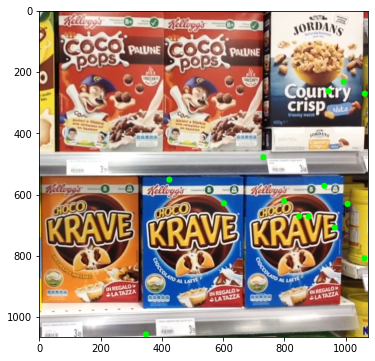

In [237]:
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

for i in range(len(img_train)):
    for j in range(len(img_query)):
        res = most_voted_barycentres(barycenteres_votes[i][j])
        for barycentre in res[0]:
            if res[1] > 1:
                img_train_rgb[i] = cv2.circle(img_train_rgb[i], barycentre,radius=10, color=color, thickness=-1)
                print("[scene {} - image {}] barycentre {} added to image.".format(scenes[i], models[j], barycentre))
        print("[scene {} - image {}] found {} barycentres with {} votes.".format(scenes[i], models[j], len(res[0]), res[1]))
    plt.figure(figsize = (40,6))
    plt.imshow(img_train_rgb[i])
    plt.show()

### 6. Position Estimation
We can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.

In [210]:
def check_overlap(dst, j):
    if j == 0:
        return -1
    
    control_centroid = dst[j].mean(axis=0)
    print('examining image #{} with centroid = {}'.format(j,control_centroid))
    
    for i in range(j):
        if dst[i] is not None:
            centroid = dst[i].mean(axis=0)
            print('confronting with image #{} with centroid = {}'.format(i,centroid))
            
            difference = np.absolute(centroid-control_centroid)
            if difference[0][0] <= 15.0 and difference[0][1] <=15.0:
                return i
    return -1

In [211]:
# Checking if we found enough matching
img_train_rgb = []
for p in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

if resize:
    MIN_MATCH_COUNT = 116 
else:
    MIN_MATCH_COUNT = 80
    
matchesMask = np.empty(len(img_train), dtype=object)
dst = np.empty(len(img_train), dtype=object)
color = (0, 255, 0)

for i in range(len(img_train)):
    cur_kp_train = kp_train[i]
    matchesMask[i] = np.empty(len(img_query), dtype=object)
    dst[i] = np.empty(len(img_query), dtype=object)
    for j in range(len(img_query)):
#         if len(good[i][j])>MIN_MATCH_COUNT:
        cur_kp_query = kp_query[j]
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ cur_kp_query[m.queryIdx].pt for m,n in matches_per_image[i][j] ]).reshape(-1,1,2)
        dst_pts = np.float32([ cur_kp_train[m.trainIdx].pt for m,n in matches_per_image[i][j] ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Mask of discarded point used in visualization
        matchesMask[i][j] = mask.ravel().tolist()
        # Corners of the query image
        h,w = img_query[j].shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        # Projecting the corners into the train image
#         dst[i][j] = cv2.perspectiveTransform(pts,M)

#         overlap_idx = check_overlap(dst[i], j)
#         if overlap_idx > -1:
#             if len(good[i][j]) >= len(good[i][overlap_idx]):
#                 dst[i][overlap_idx] = None
#             else:
#                 dst[i][j] = None         
#         else:
#             print( "Not enough matches are found - {}/{}".format(len(good[i][j]), MIN_MATCH_COUNT) )
#             matchesMask[i][j] = None
            
#     for j in range(len(img_query)):
#         if dst[i][j] is not None:
#             print('drawing on scene #{} bounding box #{}'.format(i,j))
#             # Drawing the bounding box
#             img_train_rgb[i] = cv2.polylines(img_train_rgb[i],[np.int32(dst[i][j])],True,color,3, cv2.LINE_AA)

Finally, if we want to draw the matches we can do it in the following way:

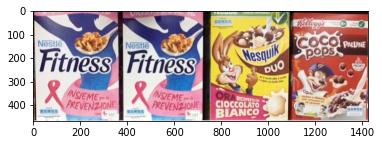

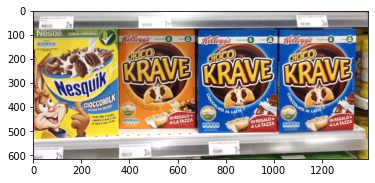

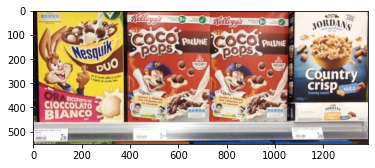

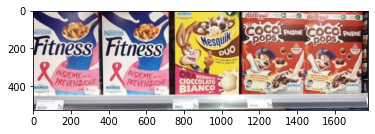

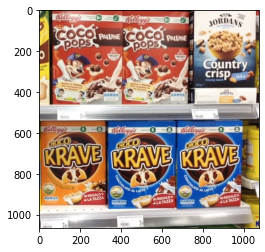

In [212]:
for img in img_train_rgb:
    plt.imshow(img)
    plt.show()

In [213]:
# Drawing the matches
for i in range(len(img_train)):
    for j in range(len(img_query)):
#         if len(good[i][j])>MIN_MATCH_COUNT:
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
               singlePointColor = None, # not draw keypoints only matching lines
               matchesMask = matchesMask[i][j], # draw only inliers
               flags = 2) # not draw keypoints only lines
        img3 = cv2.drawMatches(img_query[j],kp_query[j],img_train[i],kp_train[i],good[i][j],None,**draw_params)
        plt.imshow(img3, 'gray')
        plt.show()
        print(len(good[i][j]))

error: OpenCV(4.5.4) /tmp/pip-req-build-24v3eisa/opencv/modules/features2d/src/draw.cpp:228: error: (-201:Incorrect size of input array) matchesMask must have the same size as matches1to2 in function 'drawMatches'
